<a href="https://colab.research.google.com/github/bernatsort/Chest_X_Ray_Medical_Diagnosis_with_CNN/blob/main/covid19_pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image preprocessing and Model building

## Libraries

Install and import the Keras Tuner.

In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import DirectoryIterator

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# Type hint
from typing import Tuple

<ipython-input-2-46e628a4553a>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# Mount Google Drive to store and load files. 
from google.colab import drive
drive.mount('drive') # mounting Google Drive

Mounted at drive


In [ ]:
path = '/content/drive/MyDrive/ComputerVision'

In [ ]:
train_dir = path + '/Lungs_Dataset/train'
val_dir = path + '/Lungs_Dataset/val'
test_dir = path + '/Lungs_Dataset/test'

# Image Preprocessing

Configuración de `ImageDataGenerator`: 

- `rotation_range`: especifica el rango de rotaciones aleatorias que se pueden aplicar a las imágenes, en grados. En este caso, las imágenes se pueden rotar hasta 20 grados en cualquier dirección.

- `width_shift_range` y `height_shift_range`: controlan el rango de desplazamientos horizontales y verticales aleatorios que se pueden aplicar a las imágenes. Un valor de 0.1 significa que las imágenes pueden desplazarse horizontal o verticalmente hasta un 10% de la anchura o altura de la imagen.

- `shear_range`: determina el rango de transformaciones de cizallamiento aleatorias que se aplicarán. La cizalladura distorsiona la forma de la imagen desplazando cada fila de píxeles un ángulo determinado. Un valor de 0.1 significa que las imágenes se pueden distorsionar hasta 10 grados.

- `zoom_range`: especifica el rango de zoom aleatorio que se aplicará. El zoom cambia la escala de la imagen. Un valor de 0.1 significa que las imágenes pueden ampliarse o reducirse hasta un 10%.

- `samplewise_center`: cuando se establece en `True`, este parámetro resta la media de cada imagen de cada píxel. Esto centra los valores de los píxeles alrededor de 0.

- `samplewise_std_normalization`: cuando se establece en `True`, este parámetro divide cada píxel por su desviación estándar. Esto normaliza los valores de los píxeles para que tengan media 0 y desviación estándar 1.

Estas técnicas de aumento y preprocesamiento ayudan a introducir variaciones y mejorar la robustez del modelo, es decir, su capacidad de generalización. 



In [ ]:
image_generator = ImageDataGenerator(
                                      rotation_range=20,
                                      width_shift_range=0.1,
                                      shear_range=0.1,
                                      zoom_range=0.1,
                                      samplewise_center=True,
                                      samplewise_std_normalization=True
                                     )

Una vez configurado el `ImageDataGenerator`, utilizamos su método `flow_from_directory` para crear generadores de imágenes para los conjuntos de train, validation y test. Estos generadores aplicarán los aumentos especificados y preprocesarán las imágenes sobre la marcha durante el entrenamiento y la evaluación del modelo.

In [ ]:
train_generator = image_generator.flow_from_directory(train_dir, 
                                                      batch_size=8, # 8 images por lote
                                                      # Barajar los datos antes de cada epoch durante el entrenamiento,
                                                      # asegurando que el modelo ve los datos en un orden diferente en cada epoch.
                                                      shuffle=True, 
                                                      # Classification task with multiple classes (normal, pneumonia, and COVID-19)
                                                      class_mode='categorical',
                                                      target_size=(224, 224)) # resize

validation_generator = image_generator.flow_from_directory(val_dir, 
                                                           batch_size=1, # procesamos una imagen cada vez
                                                           shuffle=False, 
                                                           class_mode='categorical',
                                                           target_size=(224, 224))

test_generator = image_generator.flow_from_directory(test_dir, 
                                                     batch_size=1, # procesamos una imagen cada vez 
                                                     shuffle=False, 
                                                     class_mode='categorical',
                                                     target_size=(224, 224))

Found 4115 images belonging to 3 classes.
Found 1029 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


## Preprocessed Image Visualization 

In [ ]:
def plot_preprocessed_images(train: DirectoryIterator, num_images_per_class: int) -> None:
    """
    Plots preprocessed images from each class in the training set.

    Args:
        train (DirectoryIterator): The training data iterator.
        num_images_per_class (int): Number of preprocessed images to plot from each class.

    Returns:
        None
    """
    # Initialize counters for each class
    normal_count = 0
    pneumonia_count = 0
    covid_count = 0

    # Plot preprocessed images from each class
    fig, axes = plt.subplots(3, num_images_per_class, figsize=(12, 9))

    for images, labels in train:
        for i in range(len(images)):
            # Get the corresponding class label
            class_label = labels[i]

            # Plot the image based on the class label
            if class_label[0] == 1:
                if covid_count < num_images_per_class:
                    axes[0, covid_count].imshow(images[i])
                    axes[0, covid_count].set_title('COVID-19')
                    axes[0, covid_count].axis('off')
                    covid_count += 1
            elif class_label[1] == 1:
                if normal_count < num_images_per_class:
                    axes[1, normal_count].imshow(images[i])
                    axes[1, normal_count].set_title('NORMAL')
                    axes[1, normal_count].axis('off')
                    normal_count += 1
            elif class_label[2] == 1:
                if pneumonia_count < num_images_per_class:
                    axes[2, pneumonia_count].imshow(images[i])
                    axes[2, pneumonia_count].set_title('PNEUMONIA')
                    axes[2, pneumonia_count].axis('off')
                    pneumonia_count += 1

        if normal_count >= num_images_per_class and pneumonia_count >= num_images_per_class and covid_count >= num_images_per_class:
            break

    plt.tight_layout()
    plt.show()


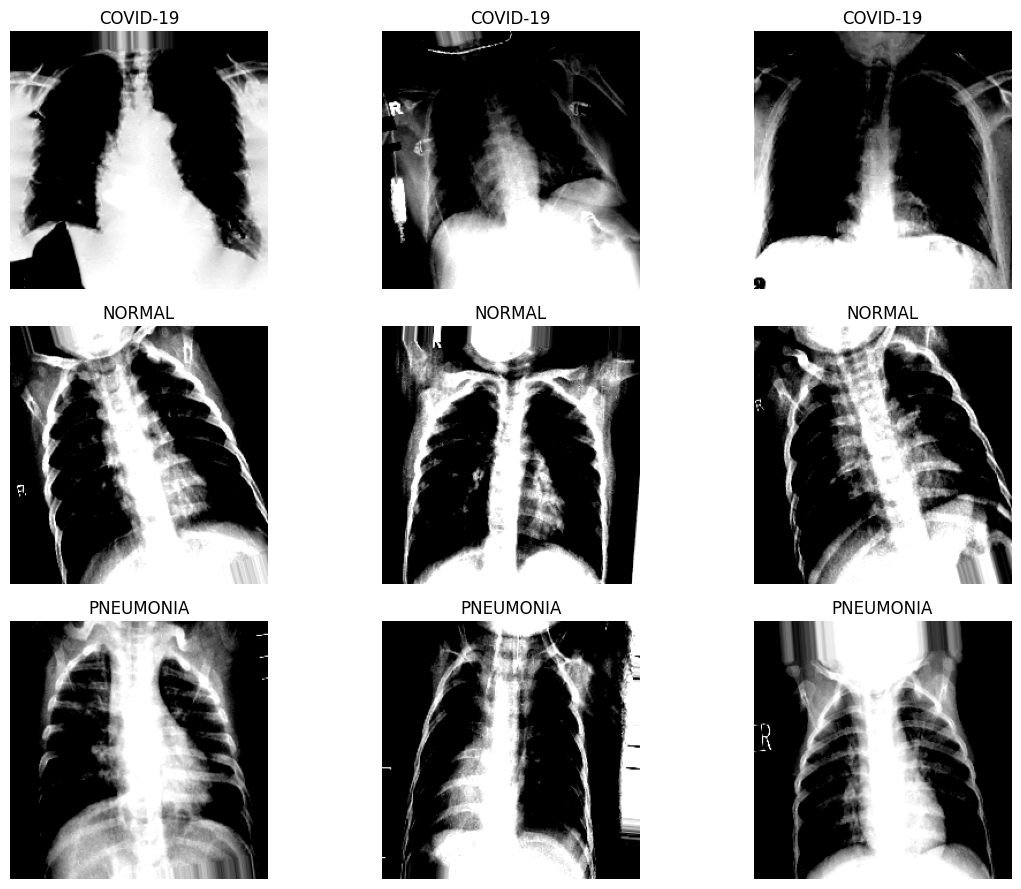

In [ ]:
plot_preprocessed_images(train=train_generator, num_images_per_class=3)

In [ ]:
def show_image_histogram_info(imagen, etiqueta):
    sns.set_style('white')

    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # Muestra la imagen en la primera fila
    axs[0].imshow(imagen, cmap='gray')
    #axs[0].colorbar()
    axs[0].set_title(f"Processed Chest X Ray Image{etiqueta}")
    axs[0].axis('off')

    # Muestra el histograma en la segunda fila
    sns.histplot(imagen.ravel(),
                 label=f"Pixel Mean {np.mean(imagen):.4f} & Standard Deviation {np.std(imagen):.4f}", 
                 kde=False, ax=axs[1])
    axs[1].legend(loc='upper center')
    axs[1].set_title('Distribution of Pixel Intensities in the Image')
    axs[1].set_xlabel('Pixel Intensity')
    axs[1].set_ylabel('# Pixels in Image')

    # Ajusta el espaciado entre las subtramas
    plt.tight_layout()

    # Muestra el subplot
    plt.show()

    print(f"The dimensions of the image are {imagen.shape[0]} pixels width and {imagen.shape[1]} pixels height, one single color channel.")
    print(f"The maximum pixel value is {imagen.max():.4f} and the minimum is {imagen.min():.4f}")
    print(f"The mean value of the pixels is {imagen.mean():.4f} and the standard deviation is {imagen.std():.4f}")

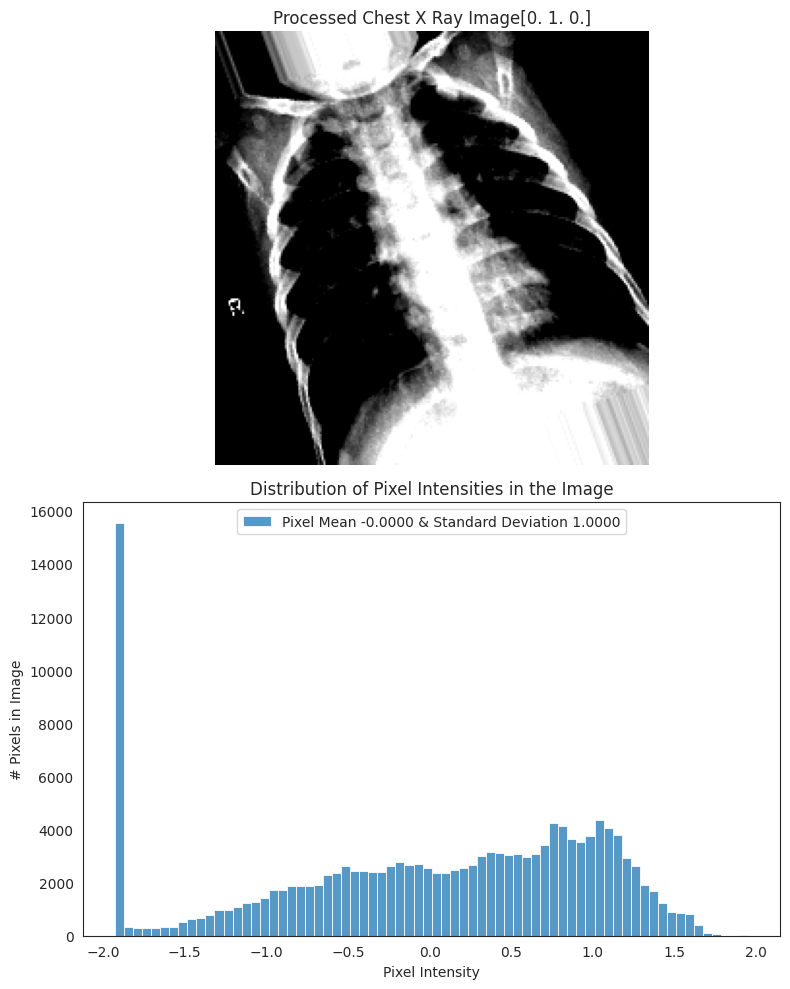

The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 1.9524 and the minimum is -1.9271
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


In [ ]:
generated_image, label = train_generator.__getitem__(0)
imagen = generated_image[0]
etiqueta = label[0]
show_image_histogram_info(imagen, etiqueta)

# Modeling 

- Tenemos desbalanceo de clases: 


In [ ]:
path = '/content/drive/MyDrive/ComputerVision'
train_dir = os.path.join(path, 'Lungs_Dataset/train')
val_dir = os.path.join(path, 'Lungs_Dataset/val')
test_dir = os.path.join(path, 'Lungs_Dataset/test')

print("Train set:\n========================================")

num_covid19_train = len(os.listdir(os.path.join(train_dir, 'COVID19')))
num_normal_train = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_pneumonia_train = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))

print(f"COVID19={num_covid19_train}")
print(f"NORMAL={num_normal_train}")
print(f"PNEUMONIA={num_pneumonia_train}")

Train set:
COVID19=368
NORMAL=1013
PNEUMONIA=2734


##  Cost-sensitive learning: class weights

 Calculamos los pesos de clase para datos desequilibrados en un problema de clasificación multi-clase:



$$
\text{weight_for_class} = \frac{{\text{total_samples}}}{{3 \cdot \text{number_of_samples_in_class}}}
$$




In [ ]:
total_samples = num_covid19_train + num_normal_train + num_pneumonia_train

weight_for_0 = total_samples / (3 * num_covid19_train)
weight_for_1 = total_samples / (3 * num_normal_train)
weight_for_2 = total_samples / (3 * num_pneumonia_train)

class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print(f"Weight for class 0 (COVID-19): {weight_for_0:.2f}")
print(f"Weight for class 1 (NORMAL): {weight_for_1:.2f}")
print(f"Weight for class 2 (PNEUMONIA): {weight_for_2:.2f}")

Weight for class 0 (COVID-19): 3.73
Weight for class 1 (NORMAL): 1.35
Weight for class 2 (PNEUMONIA): 0.50


In [ ]:
class_weights

{0: 3.727355072463768, 1: 1.3540638367884172, 2: 0.5017069007559132}

- Estos pesos reflejan el desequilibrio del conjunto de datos, asignando una mayor importancia a la clase COVID-19, una importancia moderada a la clase NORMAL y una menor importancia a la clase PNEUMONIA durante el entrenamiento.

## Hyperparameter tuning: keras tuner

In [ ]:
# Define the model-building function
def build_model(hp):
    """
    Builds a convolutional neural network model with hyperparameter tuning.

    Parameters:
    - hp (kerastuner.HyperParameters): HyperParameters object for tuning the model.

    Returns:
    - keras.Sequential: The compiled model.
    """
  model = keras.Sequential()

  # Tune the number of convolutional layers
  for i in range(hp.Int('num_conv_layers', min_value=1, max_value=4)):
      model.add(layers.Conv2D(hp.Int(f'filters_{i}', min_value=32, max_value=256),
                              kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
                              activation='relu'))
      model.add(layers.MaxPooling2D(pool_size=hp.Choice(f'pool_size_{i}', values=[2, 3])))

  model.add(layers.Flatten())

  # Tune the number of dense layers
  for i in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):
      model.add(layers.Dense(units=hp.Int(f'num_units_{i}', min_value=64, max_value=512),
                              activation='relu'))
      # Tune the dropout rate
      model.add(layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5)))

  model.add(layers.Dense(3, activation='softmax'))  # 3 classes: COVID19, NORMAL, PNEUMONIA

  # Tune the learning rate and optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

  model.compile(optimizer=hp_optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

Ejecutamos la búsqueda de hiperparámetros utilizando `RandomSearch` de `keras_tuner` para encontrar la mejor combinación de hiperparámetros que maximice la accuracy en la validación del modelo de clasificación multiclase de COVID19, NORMAL y PNEUMONIA.

In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy', # the tuner will search for hyperparameters that maximize the validation accuracy
    max_trials=2, #10  # Number of hyperparameter combinations to try: the tuner will explore 10 different combinations of hyperparameters
    executions_per_trial=1, #2 # Number of times to train the model per trial: each hyperparameter configuration will be trained and evaluated twice with different random initializations.
    directory= path + '/tuner_directory',  # Directory to store the tuning results
    project_name='covid_pneumonia_classif_tuner'  # Name of the tuning project
    )

# Define the early stopping callback: create a callback to stop training early after reaching a certain value for the validation loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=5) # stop training if the validation loss doesn't improve for 5 consecutive epochs

# Run the hyperparameter search. 
# The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.
# Perform the hyperparameter search
tuner.search(train_generator, 
             epochs=10, 
             batch_size=32,
             validation_data=validation_generator, 
             callbacks=[early_stopping]
             )


Trial 2 Complete [00h 43m 59s]
val_accuracy: 0.9465500712394714

Best val_accuracy So Far: 0.9465500712394714
Total elapsed time: 01h 23m 21s


- El resultado de la búsqueda de hiperparámetros muestra que la mejor accuracy en la validación alcanzada hasta ahora es de 0.946. Esto significa que el modelo con la combinación de hiperparámetros asociada a este resultado obtuvo una accuracy del 94.6% en la clasificación de las muestras de validación.
- El objetivo de la búsqueda de hiperparámetros es maximizar la accuracy en la validación, por lo que el mejor resultado encontrado hasta ahora indica que se ha logrado un buen rendimiento en la clasificación de las clases COVID19, NORMAL y PNEUMONIA.
- El resultado actual muestra un buen punto de partida para el modelo de clasificación multiclase.

Extraemos los mejores hiperparámetros encontrados durante la búsqueda:

In [ ]:
# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
  # get_best_hyperparameters() method without specifying the num_trials parameter returns a list of all the best hyperparameters found during the search, sorted by their performance. 
  # By accessing the first element of the list [0], you will obtain the hyperparameters with the highest performance.

# Print the best hyperparameters 
print("Best Hyperparameters:")
print(f"- Number of Convolutional Layers: {best_hp.get('num_conv_layers')}")
for i in range(best_hp.get('num_conv_layers')):
    print(f"  - Filters in Convolutional Layer {i+1}: {best_hp.get(f'filters_{i}')}")
    print(f"  - Kernel Size in Convolutional Layer {i+1}: {best_hp.get(f'kernel_size_{i}')}")
    print(f"  - Pooling Size in Convolutional Layer {i+1}: {best_hp.get(f'pool_size_{i}')}")
print(f"- Number of Dense Layers: {best_hp.get('num_dense_layers')}")
for i in range(best_hp.get('num_dense_layers')):
    print(f"  - Number of Units in Dense Layer {i+1}: {best_hp.get(f'num_units_{i}')}")
    print(f"  - Dropout Rate in Dense Layer {i+1}: {best_hp.get(f'dropout_rate_{i}')}")
print(f"- Learning Rate: {best_hp.get('learning_rate')}")
print(f"- Optimizer: {best_hp.get('optimizer')}")

Best Hyperparameters:
- Number of Convolutional Layers: 4
  - Filters in Convolutional Layer 1: 156
  - Kernel Size in Convolutional Layer 1: 3
  - Pooling Size in Convolutional Layer 1: 2
  - Filters in Convolutional Layer 2: 149
  - Kernel Size in Convolutional Layer 2: 3
  - Pooling Size in Convolutional Layer 2: 2
  - Filters in Convolutional Layer 3: 192
  - Kernel Size in Convolutional Layer 3: 3
  - Pooling Size in Convolutional Layer 3: 3
  - Filters in Convolutional Layer 4: 254
  - Kernel Size in Convolutional Layer 4: 5
  - Pooling Size in Convolutional Layer 4: 2
- Number of Dense Layers: 2
  - Number of Units in Dense Layer 1: 188
  - Dropout Rate in Dense Layer 1: 0.4296478261801449
  - Number of Units in Dense Layer 2: 310
  - Dropout Rate in Dense Layer 2: 0.20158293434446
- Learning Rate: 0.01
- Optimizer: adam


A modo de ejemplo y para un mayor entendimiento, el modelo con los mejores hiperparámetros quedaría de la siguiente manera: 

In [3]:
def best_model():
    model = keras.Sequential()
    input_shape = (224, 224, 3)
    
    # Convolutional layers
    model.add(layers.Conv2D(156, kernel_size=3, activation='relu', input_shape=(input_shape)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(149, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(192, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=3))
    model.add(layers.Conv2D(254, kernel_size=5, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(188, activation='relu'))
    model.add(layers.Dropout(0.4296478261801449))
    model.add(layers.Dense(310, activation='relu'))
    model.add(layers.Dropout(0.20158293434446))
    model.add(layers.Dense(3, activation='softmax'))  # 3 classes: COVID19, NORMAL, PNEUMONIA

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                  loss='categorical_crossentropy', # categorical_crossentropy loss function porque es Multi-class
                  metrics=['accuracy'])

    return model

# Create the model
best_model = best_model()

## Model Training

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model = tuner.hypermodel.build(best_hp)

# Train the best model
history = model.fit(train_generator, 
                    epochs=10,
                    batch_size=32,
                    validation_data=validation_generator, 
                    class_weight=class_weights
                    )

# To save the model once it has been trained 
model.save(path + '/models/model_1_cnn.h5')

Epoch 1/10
515/515 [==============================] - 1493s 3s/step - loss: 0.6904 - accuracy: 0.6574 - val_loss: 0.4946 - val_accuracy: 0.8056
Epoch 2/10
515/515 [==============================] - 230s 446ms/step - loss: 0.4876 - accuracy: 0.7968 - val_loss: 0.3230 - val_accuracy: 0.8853
Epoch 3/10
515/515 [==============================] - 213s 414ms/step - loss: 0.3488 - accuracy: 0.8498 - val_loss: 0.3542 - val_accuracy: 0.8542
Epoch 4/10
515/515 [==============================] - 255s 495ms/step - loss: 0.2968 - accuracy: 0.8700 - val_loss: 0.2545 - val_accuracy: 0.9009
Epoch 5/10
515/515 [==============================] - 232s 450ms/step - loss: 0.3268 - accuracy: 0.8671 - val_loss: 0.3798 - val_accuracy: 0.8649
Epoch 6/10
515/515 [==============================] - 226s 438ms/step - loss: 0.2550 - accuracy: 0.8943 - val_loss: 0.3794 - val_accuracy: 0.8503
Epoch 7/10
515/515 [==============================] - 272s 528ms/step - loss: 0.2534 - accuracy: 0.8914 - val_loss: 0.2756 - v

- En general, se observa que tanto la loss como la accuracy mejoran a medida que el modelo se entrena durante más épocas. La accuracy en el conjunto de validación alcanza un valor de 0.9096 en en la última época, lo que indica que el modelo tiene un buen rendimiento para clasificar las imágenes de radiografías pulmonares en las tres clases (COVID19, NORMAL y NEUMONÍA) en el conjunto de validación. 

In [ ]:
# save the weights
model.save_weights('/content/drive/MyDrive/ComputerVision/models/model_weights_1')

In [ ]:
# To save the model once it has been trained 
model.save('/content/drive/MyDrive/ComputerVision/models/model_lung_classif_3')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 156)   4368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 156)  0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 149)   209345    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 149)  0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 192)   257664    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 192)  0

In [ ]:
# Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 10


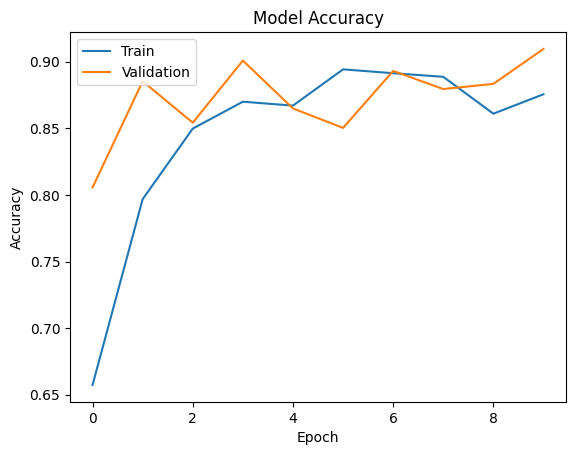

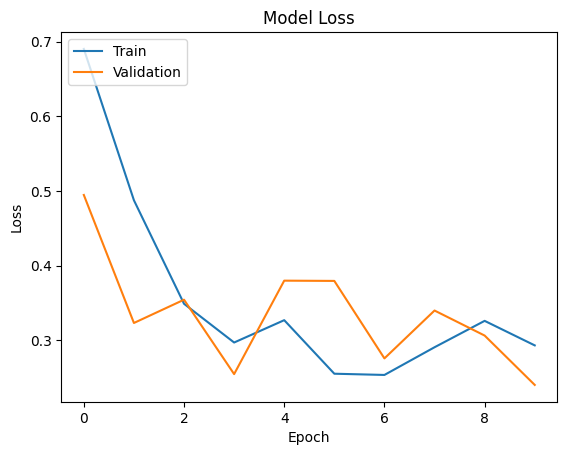

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- Podemos observar la tendencia de la accuracy y la loss tanto en el conjunto de entrenamiento como en el conjunto de validación. 
- Si la accuracy del conjunto de entrenamiento continuara aumentando mientras que la del conjunto de validación se estanca o disminuye, podría ser un indicio de sobreajuste (overfitting). En este caso, en ambos conjuntos mejora de manera similar, indicando que el modelo generaliza bien.
- El gráfico de pérdida (loss) permite observar si el modelo está convergiendo y si hay signos de sobreajuste (overfitting)o subajuste (underfitting). Una disminución en la pérdida tanto en el conjunto de entrenamiento como en el conjunto de validación es deseable, ya que indica que el modelo está aprendiendo correctamente los patrones en los datos.

## Model Evaluation

Evaluating the model on a separate test set.


In [ ]:
# Evaluate the best model on the test set
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 55s 42ms/step - loss: 0.2133 - accuracy: 0.9154
Test Accuracy: 91.54%
515/515 [==============================] - 188s 366ms/step - loss: 0.2211 - accuracy: 0.9181
Train Accuracy: 91.81%


Predictions: 

In [ ]:
predicted = model.predict(test_generator) # y_score

1288/1288 [==============================] - 416s 323ms/step


In [ ]:
predicted # predicted.shape: (1288, 3)

array([[9.8909879e-01, 1.1738632e-03, 9.7273160e-03],
       [9.9117053e-01, 6.8219990e-04, 8.1472266e-03],
       [9.5749718e-01, 4.2186748e-02, 3.1608902e-04],
       ...,
       [1.1928886e-02, 1.2874314e-01, 8.5932803e-01],
       [3.0339039e-03, 5.2532011e-01, 4.7164601e-01],
       [7.4127357e-04, 1.7066276e-02, 9.8219246e-01]], dtype=float32)

In [ ]:
# np.argmax(p) devuelve el índice del valor máximo en p, que corresponde a la clase con la probabilidad más alta según la salida softmax del modelo
predictedClass = [np.argmax(p) for p in predicted] # contiene las clases predichas para cada muestra en el test set

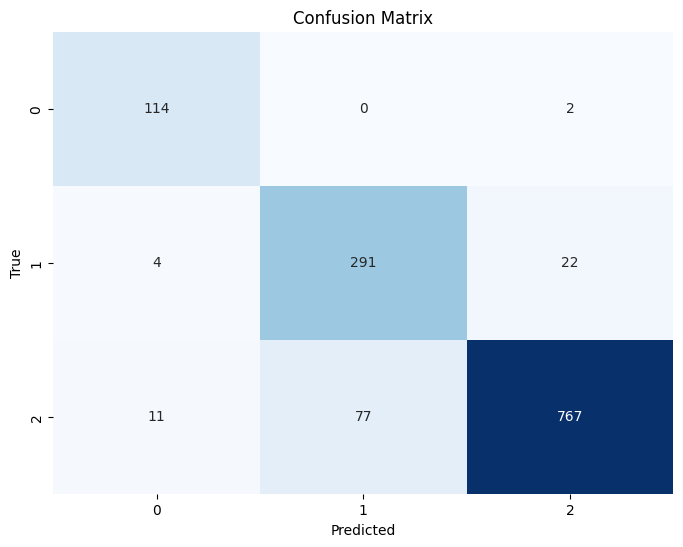

In [ ]:
# Get the true class labels
trueClass = test_generator.classes # array([0, 0, 0, ..., 2, 2, 2], dtype=int32; trueClass.shape: (1288,)

# Compute the confusion matrix
cm = confusion_matrix(trueClass, predictedClass)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
target_names = ['Class 0: COVID19', 'Class 1: NORMAL', 'Class 2: PNEUMONIA']
print(classification_report(trueClass, predictedClass, target_names=target_names))

                    precision    recall  f1-score   support

  Class 0: COVID19       0.88      0.98      0.93       116
   Class 1: NORMAL       0.79      0.92      0.85       317
Class 2: PNEUMONIA       0.97      0.90      0.93       855

          accuracy                           0.91      1288
         macro avg       0.88      0.93      0.90      1288
      weighted avg       0.92      0.91      0.91      1288



- El modelo tiene un rendimiento sólido en general, con una precisión ponderada promedio del 92% y una recuperación ponderada promedio del 91% y una puntuación F1 ponderada promedio del 91%. No obstante, estas puntuaciones ponderadas favorecen a las clases mayoritarias (PNEUMONIA) porque se ponderan más en el cálculo.

- La puntuación F1 macromediada es un enfoque en el que calculamos la puntuación F1 para cada categoría y luego promediamos todos los resultados. Este método penaliza el modelo por igual para cualquier clase que no funcione bien, independientemente de su importancia o de cuántas muestras tenga. En nuestro caso es del 90%. Esto indica que el modelo es capaz de clasificar correctamente las muestras en general y tiene un buen equilibrio entre precisión y recuperación en todas las clases.


- En conclusión, nuestro modelo ha logrado un buen rendimiento en la clasificación de las imágenes de rayos X de los pulmones de pacientes con COVID-19, neumonía y sanos. En un futuro, se podría considerar ajustar el modelo o recopilar más datos para mejorar el rendimiento para las clases que tienen una puntuación F1 más baja, como la clase NORMAL, es decir, para los pacientes sanos.

## Load Model

In [ ]:
# Load the model
new_model = tf.keras.models.load_model('/content/drive/MyDrive/ComputerVision/models/model_lung_classif_3')
# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 156)   4368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 156)  0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 149)   209345    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 149)  0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 192)   257664    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 192)  0